###Linear Gaussian Estimation




#### Recursive Least Squares (RLS)

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import padasip as pa

In [3]:
# Signal creation: u, v, d
N = 2000  # length of test sequence
n = 64  # filter length
Nx = 10.0
u = np.sin(np.arange(0, N/Nx, N/(Nx*N)))  # signal: a sin wave 
v = 2.0*(np.random.random(N) - 0.5)  # white noised
d = u + v  # signal + noise = observed signal


# Construct an array of observations, one for each row. 
# Each row is a data point and the past n-1 lags of data point. Finally drop the last row ([:-1]).
# note: x will be shape: (N-n,n)
x = pa.input_from_history(d, n)[:-1]
d = d[n:]  # drop the first n data points to match the number of rows in x
u = u[n:]  # drop the first n data points to match the number of rows in x

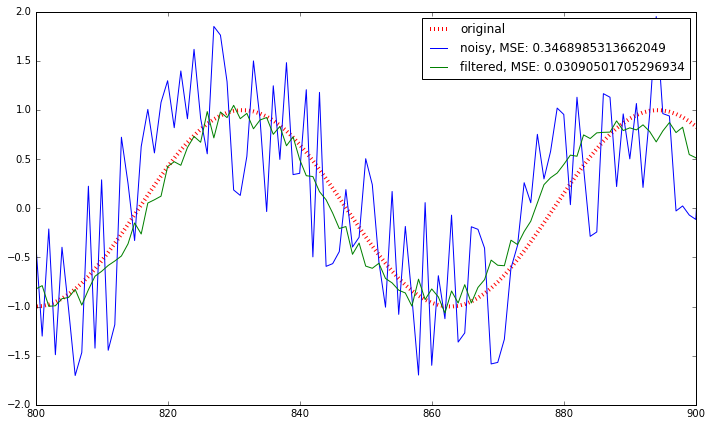

In [4]:
# --- filtering ---
#  Filter the data in x using d as the desired output. Here x and d are the same data only x
# is in a format used to apply the filter
# output is: y - the filter output (filtered x), e - error signal, w - adaptive filter coefficients
y, e, w = pa.rls_filter(d, x, mu=0.95)

# error estimation
MSE_d = np.dot(u-d, u-d) / float(len(u))
MSE_y = np.dot(u-y, u-y) / float(len(u))

# results
plt.figure(figsize=(10.0, 6))
plt.plot(u, "r:", linewidth=4, label="original")
plt.plot(d, "b", label="noisy, MSE: {}".format(MSE_d))
plt.plot(y, "g", label="filtered, MSE: {}".format(MSE_y))
plt.xlim(800, 900)
plt.legend()
plt.tight_layout()
plt.show()

The figure above shows a section of the signal (points 800 through 900). The clean signal is in red, the noisy signal in blue and the filtered signal in green. The filtered signal can be seen to be much closer to the original signal.

Next we will implement the filter to work on a stream of data. The function 'predict' filters the data in x to produce a value y. The filter is updated in the function 'adapt' at every time step.

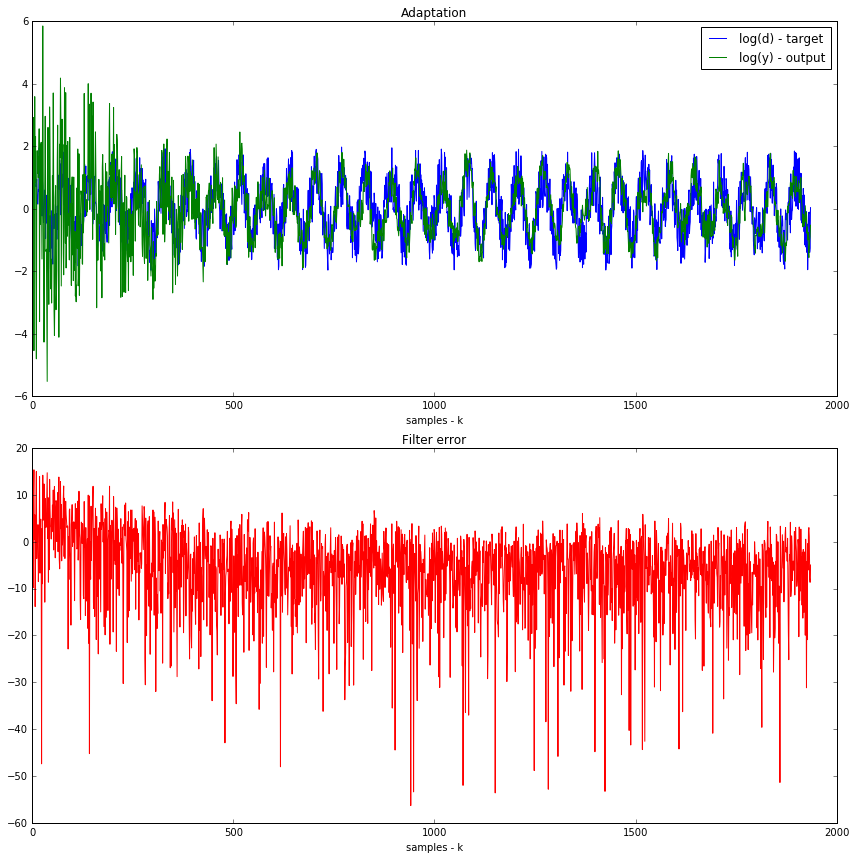

In [5]:
Nx = N - n
log_d = np.zeros(Nx)
log_y = np.zeros(Nx)
y = np.zeros(Nx)
filt = pa.filters.FilterRLS(n, mu=0.5)
for k in range(Nx):
    # predict new value using the measured signal x
    y[k] = filt.predict(x[k, :])
    # update filter using the desired signal d and the measured signal x
    filt.adapt(d[k], x[k, :])
    # log values
    log_d[k] = d[k]
    log_y[k] = y[k]
    
# show results
plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.title("Adaptation")
plt.xlabel("samples - k")
plt.plot(log_d, "b", label="log(d) - target")
plt.plot(log_y, "g", label="log(y) - output")
plt.legend()
plt.subplot(212)
plt.title("Filter error")
plt.xlabel("samples - k")
plt.plot(10*np.log10((log_d-log_y)**2), "r", label="e - error [dB]")
plt.tight_layout()
plt.show()

The first of the above two plots shows the log of the measured and filtered signal. The filtered signal begins (in green) with large deviations from the measured signal because the filter coefficients have not converged. After about 500 iterations convergence has been achieved and the two signal are more aligned. The second plot shows the log error over time. It shows more directly this reduction in error.

The next plot shows the section from 1800 to 1900 with a linear plot of the values.

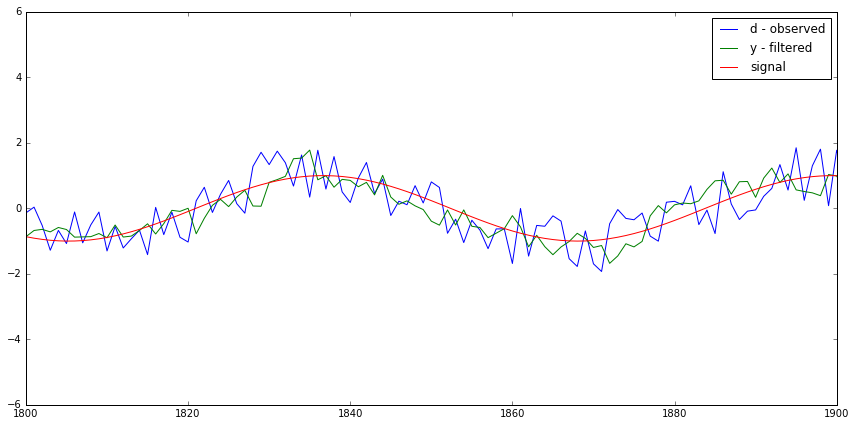

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(d, "b", label="d - observed")
plt.plot(y, 'g', label='y - filtered')
plt.plot(u, 'r', label='signal')
plt.legend(); plt.tight_layout()
plt.xlim(1800, 1900)
plt.tight_layout()
plt.show()